In [9]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [2]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Общие сведения об эксперименте: \
1 - контрольная группа \
2 - тестовая группа \
Эксперимент проходил с 2023-01-01 по 2023-01-07 включительно \
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

In [4]:
# 1 - контрольная группа
# 2 - тестовая группа

query = '''
SELECT exp_group, user_id,
    sum(action = 'like') as likes, 
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2023-01-01' 
    AND toDate(time) <= '2023-01-07'
    AND exp_group in (1, 2)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [9]:
# проверили разбиение
df.groupby('exp_group').count().user_id

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

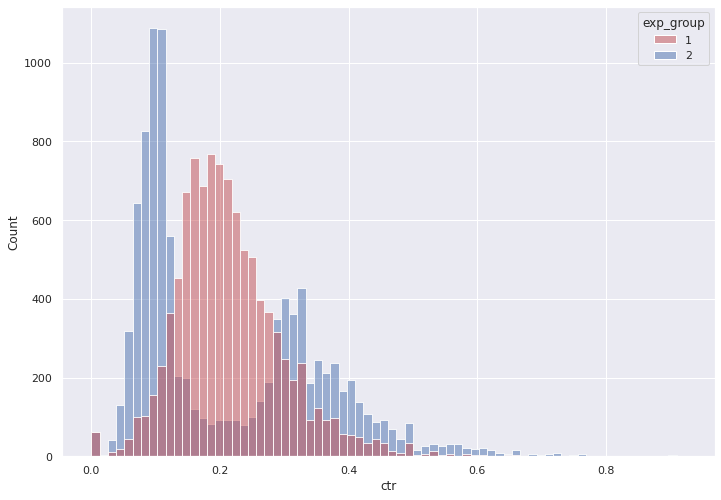

In [5]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Визуально распределения групп отличаются друг от друга

## Тест Манна-Уитни на распределении пользователей

In [6]:
sample_1 = df[df.exp_group == 1].ctr.to_numpy()
sample_2 = df[df.exp_group == 2].ctr.to_numpy()

In [8]:
stats.mannwhitneyu(sample_1, 
                   sample_2,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

p_value больше 0.05, значит различие в распределениях групп согласно тесту Манна-Уитни не было выявлено

## Пуассоновский бутстреп

In [29]:
def poisson_bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [30]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = poisson_bootstrap(likes1, views1, likes2, views2)

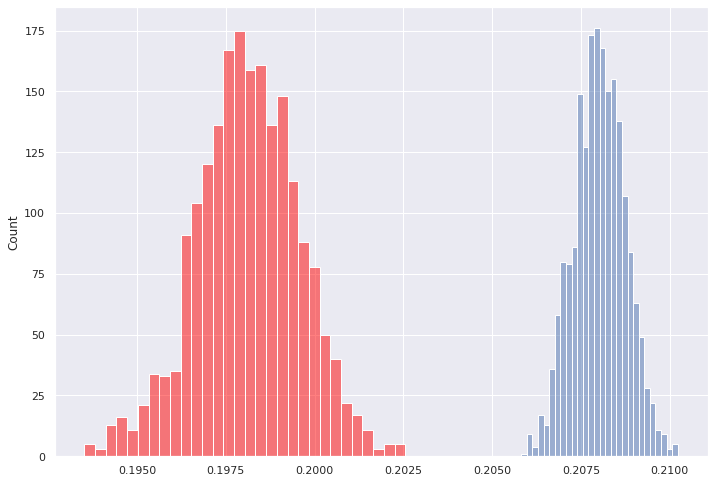

In [22]:
sns.histplot(ctr1, alpha=0.5)
sns.histplot(ctr2, color='red', alpha=0.5)
plt.show()

In [31]:
stats.mannwhitneyu(ctr1, 
                   ctr2, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=4000000.0, pvalue=0.0)

При использовании бутстрепа различие в распределениях ctr подвыборок явно видно, что подтверждает тест Манна-Уитни

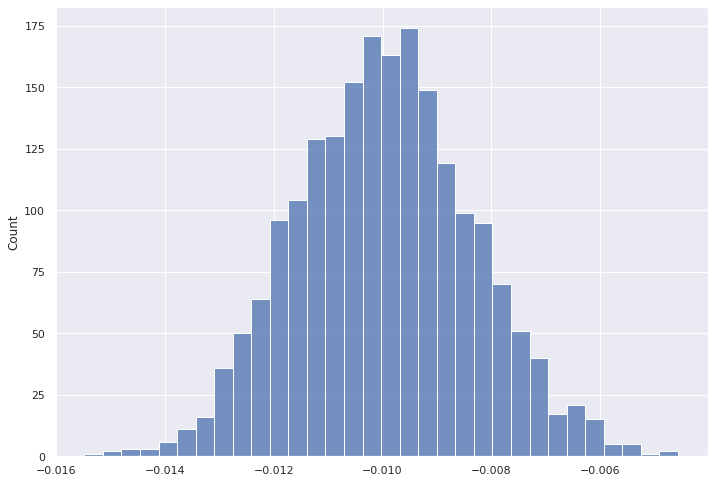

In [19]:
sns.histplot(ctr2 - ctr1)
plt.show()

## Бакетное преобразование

In [33]:
import hashlib

def ab_split(user_id, n_groups, salt='exp_mess_1'):
    test_id = str(user_id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [47]:
group1 = df[df.exp_group == 1]
group2 = df[df.exp_group == 2]

In [50]:
group1_hash, group2_hash = group1.copy(), group2.copy()
group1_hash['hash_group'] = group1.user_id.apply(ab_split, args=(100,))
group2_hash['hash_group'] = group2.user_id.apply(ab_split, args=(100,))

In [51]:
group1_hash.head()

,exp_group,user_id,likes,views,ctr,hash_group
0,1,109963,3,15,0.200000,60
1,1,26117,32,141,0.226950,19
2,1,138232,18,73,0.246575,31
3,1,26295,33,122,0.270492,14
4,1,18392,7,32,0.218750,1


In [52]:
#Кол-во групп
group1_hash.hash_group.nunique()

100

In [53]:
# посмотрим на кол-во пользователей в группе
group1_hash.hash_group.value_counts().head()

2     121
83    120
97    118
70    118
74    118
Name: hash_group, dtype: int64

In [36]:
group1_meta = group1_hash.groupby('hash_group')[['likes', 'views']].sum()
group1_meta['ctr'] = group1_meta['likes'] / group1_meta['views']
group2_meta = group2_hash.groupby('hash_group')[['likes', 'views']].sum()
group2_meta['ctr'] = group2_meta['likes'] / group2_meta['views']

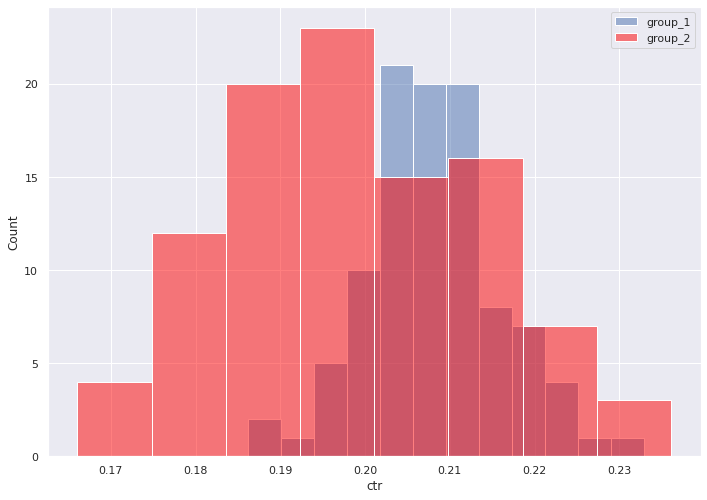

In [63]:
sns.histplot(group1_meta.ctr, alpha=0.5, label='group_1')
sns.histplot(group2_meta.ctr, color='red', alpha=0.5,label='group_2')
plt.legend()
plt.show()

In [41]:
stats.mannwhitneyu(group1_meta.ctr, 
                   group2_meta.ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=7128.0, pvalue=2.0110869513991762e-07)

При использовании бакетного преобразования различие в выборках не было выявлено

## Сглаженный CTR

In [75]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr1 = group1.likes.sum()/group1.views.sum()
global_ctr2 = group2.likes.sum()/group2.views.sum()
group1_sm, group2_sm = group1.copy(), group2.copy()
group1_sm['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr1, 5), axis=1)
group2_sm['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr2, 5), axis=1)

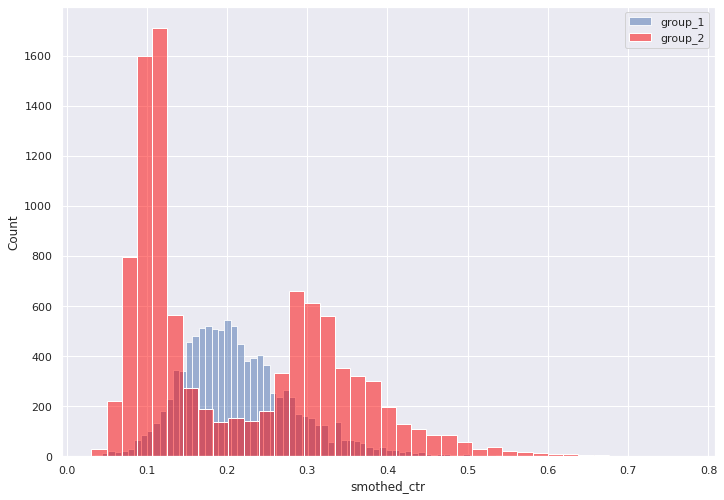

In [76]:
sns.histplot(group1_sm.smothed_ctr, alpha=0.5, label='group_1')
sns.histplot(group2_sm.smothed_ctr, color='red', alpha=0.5, label='group_2')
plt.legend()
plt.show()

In [77]:
stats.mannwhitneyu(group1_sm.smothed_ctr, 
                   group2_sm.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

## Вывод

Разница в распределениях контрольной и тестовой выборки заметно при визуальном анализе и использовании бутстрепа, однако при проведении теста Манна-Уитни на распределении метрики по пользователям и при испльзовании бакетного преобразования различие в распределениях групп не было выявлено. 
Такие результаыт можно объяснить особенностью получившихся распределений (распределение первой группы находится между двумя горбами распределения второй группы), а также теста (его нулевой гипотезой: вероятность, что значения одного распределения больше значения второго второго распределения), который применялся для их сравнения.  
Мне кажется, что не стоит раскатывать данный алгоритм на всех новых пользователей, потому что по распределению группы, к которой применялся данный алгоритм видно, что для ее одной части целевая стала метрика хуже, чем в контрольной группе, хоть для другой части пользователей метрика и увеличилась, одноко при применении бутстрепа видно, распределение метрики по подвыборкам в treatment группе стоит левее, чем в контрольной.